# Example for:
Clustering Experiment from all other classes of FashionMNIST to shoes (Sandal, Sneaker, Ankle boot) classes in FashionMNIST

# Setup and utils

In [1]:
import sys
sys.path.append('/home/arnisaf/mp-tl-study')
from functions.utils import *
from functions.clustering_utils import *
from functions.visualization_utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5]

### Load the pretrained model as a feature extractor

In [8]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 5,
      'num_channels': 30, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':64,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 2, 3, 4, 6, 8],
      'fine_tune_classes': [5, 7, 9],
      'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True,   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
      'truncate': False
      }

In [9]:
root_dir = './data'  # Specify your data directory here
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataloader_wrapped = TransferLearningWrapper(params, datasets.FashionMNIST, datasets.FashionMNIST, root_dir, transform=transform)

In [16]:
feature_extractor = CNNFeatureExtractor(params, dataloader_wrapped.output_dim).to(device)
feature_extractor.load_state_dict(torch.load('pretrained_models/pretrained_normal_classes_new/pretrained_model.pth'))

<All keys matched successfully>

### tSNE Visualizations

In [17]:
dataloader_wrapped.update_phase('pretrain')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

In [18]:
# sanity check
print(train_labels[:10])
print(torch.argmax(train_extracted_features["fc"][:10], dim=1))
print(test_labels[:10])
print(torch.argmax(test_extracted_features["fc"][:10], dim=1))

tensor([2., 3., 6., 0., 3., 3., 0., 3., 1., 3.])
tensor([2, 3, 6, 0, 3, 3, 0, 3, 1, 3])
tensor([0., 0., 3., 0., 2., 2., 0., 1., 0., 5.])
tensor([0, 0, 3, 5, 2, 2, 0, 1, 0, 5])


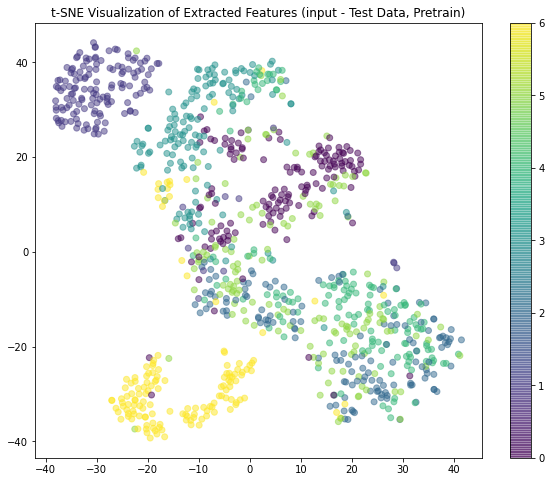

ARI of multidimensional KNN:  0.26976632179587556


In [19]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "input"
layer_features = test_extracted_features[layer_name][:1000,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[:1000], layer_name, "Test Data, Pretrain")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[:1000])
print("ARI of multidimensional KNN: ", ari)

In [20]:
dataloader_wrapped.update_phase('finetune')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

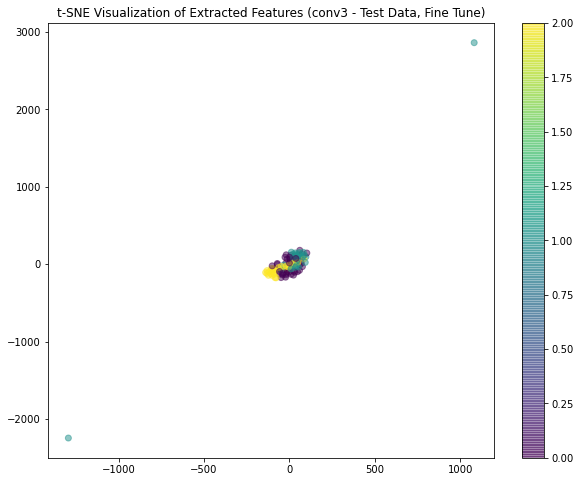

ARI of multidimensional KNN:  0.15074875275552937


In [21]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "conv3"
layer_features = test_extracted_features[layer_name][-100:,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[-100:], layer_name, "Test Data, Fine Tune")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[-100:])
print("ARI of multidimensional KNN: ", ari)

### ARI Scores Plot

In [22]:
ari_scores_all = []

In [ ]:
dataloader_wrapped.update_phase('finetune')
dataset_to_use = dataloader_wrapped.train_loader
num_samples = 1000
channel_ids = range(params["num_channels"])
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']

ari_scores_all = []
# subset the dataset (same as the empirical experiment)
for sampled_percentage in percentages:
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
    print(f"Percentage:{sampled_percentage}")

    for repeat in tqdm(range(repeats)):
        reduced_dataset = reduce_dataset(dataset_to_use, sampled_percentage, seed=repeat)
        if num_samples < len(reduced_dataset.dataset):
            num_samples_tmp = num_samples
        else:
            num_samples_tmp = 0
        pretraining_ari_scores = get_ARI_scores(reduced_dataset,num_samples_tmp, channel_ids, apply_pca=50)

        # get the max of the channels -append to another dict
        for layer, channels in pretraining_ari_scores.items():
            max_channel = max(channels.items())
            ari_scores_all.append({"Percentage":sampled_percentage, "Repeat":repeat, "Num Samples":num_samples_tmp, "Layer":layer, 
                                   "Max ARI Score":np.max(list(channels.items())), "Avg ARI Score":np.average(list(channels.items())),
                                   "Dataset":"Pretrain", "Split":"Train"})
# dict to df
df = pd.DataFrame(ari_scores_all)

In [ ]:
with open(f'results/ari_scores/ari_scores_finetuned_Fashion_regular_classes.json', 'w') as f:
    json.dump(ari_scores_all, f)